In [ ]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

# Tutorial of package GraphRicciCurvature

This is a walk through tutorial of package GraphRicciCurvature, please make sure you have the latest package to run this tutorial.

## Preparation:
### Load library

In [2]:
import networkx as nx
import numpy as np
import math
from sklearn import preprocessing, metrics

from GraphRicciCurvature.OllivierRicci import OllivierRicci

# colab setting
!pip install GraphRicciCurvature

# matplotlib setting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

/bin/sh: pip: command not found


### Load sample graph

- First, let's load karate club graph from networkx as an example.

In [3]:
G = nx.karate_club_graph()

In [4]:
print(nx.info(G))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


---
## Ollivier-Ricci curvature
- Ricci curvature is a geometric property to describe the local shape of an object. In graph, an edge with *positive curvature* represents an edge within a cluster, while a *negative curvature* edge tents to be a bridge within clusters.
- To compute the Ollivier-Ricci curvature of a graph, we can use the class `OllivierRicci` to load the graph and setup the parameter for the curvature computation.


In [5]:
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")

- After setup the class `orc`, we can call `compute_ricci_curvature` to start the Ricci curvature computation. The graph in the class with results will be updated.

In [6]:
orc.compute_ricci_curvature()
G_orc = orc.G.copy()  # safe an intermediate result

Edge weight not detected in graph, use "weight" as edge weight.


INFO:OllivierRicci:0.001369 secs for all pair by NetworKit.
INFO:OllivierRicci:Start to compute all pair density distribution for directed graph.
INFO:OllivierRicci:0.000369 secs for edge density distribution construction
INFO:OllivierRicci:0.281974 secs for Ricci curvature computation.


- The computed edge Ricci curvature is then stored in the returned networkx graph `G_orc`. Let's check the first five results and plot the histogram of the edge Ricci curvature distributions.
- The Ricci curvature distrubitions is shown to be different from graph to graph, and can be act as a graph fingerprint or graph kernal.

Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,1) is 0.111111
Ollivier-Ricci curvature of edge (0,2) is -0.143750
Ollivier-Ricci curvature of edge (0,3) is 0.041667
Ollivier-Ricci curvature of edge (0,4) is -0.114583
Ollivier-Ricci curvature of edge (0,5) is -0.281250


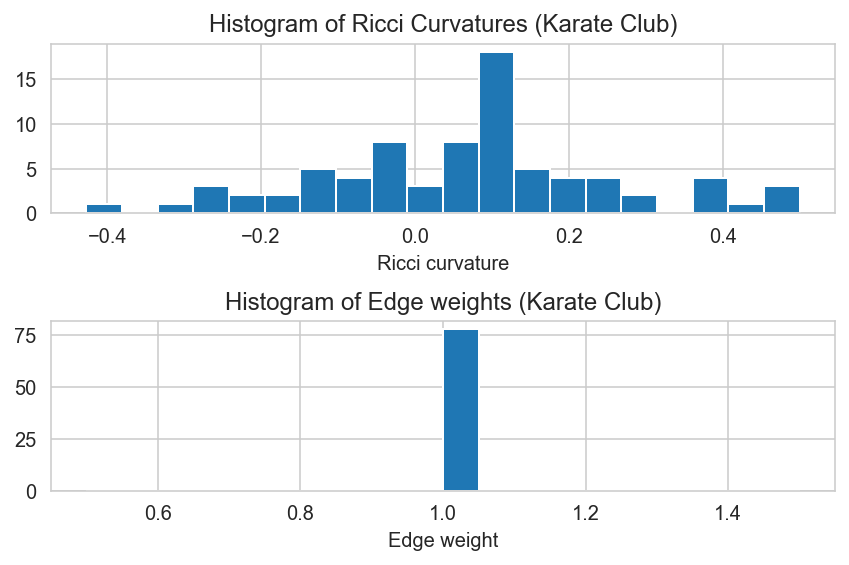

In [7]:
def show_results(G):
    # Print the first five results
    print("Karate Club Graph, first 5 edges: ")
    for n1,n2 in list(G.edges())[:5]:
        print("Ollivier-Ricci curvature of edge (%s,%s) is %f" % (n1 ,n2, G[n1][n2]["ricciCurvature"]))

    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()
    plt.hist(ricci_curvtures,bins=20)
    plt.xlabel('Ricci curvature')
    plt.title("Histogram of Ricci Curvatures (Karate Club)")

    # Plot the histogram of edge weights
    plt.subplot(2, 1, 2)
    weights = nx.get_edge_attributes(G, "weight").values()
    plt.hist(weights,bins=20)
    plt.xlabel('Edge weight')
    plt.title("Histogram of Edge weights (Karate Club)")

    plt.tight_layout()
    
show_results(G_orc)

## Ricci flow
- Ricci flow is an iterative process that aims to smooth out the curvatures of the input graph by adjusting the edges weight, it stretches edges of large negative Ricci curvature and shrinks edges of large positive Ricci curvature over time.
- To compute the Ollivier-Ricci flow, simply call function `compute_ricci_flow` to start the flow process. The iterations of flow is controled by variable `iterations`.

In [8]:
# Start a Ricci flow with Lin-Yau's probability distribution setting with 4 process.
orf = OllivierRicci(G, alpha=0.5, base=1, exp_power=0, proc=4, verbose="INFO")

# Do Ricci flow for 2 iterations
orf.compute_ricci_flow(iterations=2)

INFO:OllivierRicci:Number of nodes: 34
INFO:OllivierRicci:Number of edges: 78
INFO:OllivierRicci:Start to compute all pair shortest path.
INFO:OllivierRicci:0.001091 secs for all pair by NetworKit.
INFO:OllivierRicci:Start to compute all pair density distribution for directed graph.
INFO:OllivierRicci:0.000305 secs for edge density distribution construction


Edge weight not detected in graph, use "weight" as edge weight.


INFO:OllivierRicci:0.343114 secs for Ricci curvature computation.
INFO:OllivierRicci: === Ricci flow iteration 0 === 
INFO:OllivierRicci:0.228157 secs for Ricci curvature computation.
INFO:OllivierRicci:Ricci curvature difference: 0.927083
INFO:OllivierRicci:max:0.500000, min:-0.427083 | maxw:1.535912, minw:0.538130
INFO:OllivierRicci: === Ricci flow iteration 1 === 
INFO:OllivierRicci:Start to compute all pair shortest path.
INFO:OllivierRicci:0.011109 secs for all pair by NetworKit.
INFO:OllivierRicci:Start to compute all pair density distribution for directed graph.
INFO:OllivierRicci:0.000298 secs for edge density distribution construction
INFO:OllivierRicci:0.345306 secs for Ricci curvature computation.
INFO:OllivierRicci:Ricci curvature difference: 0.620809
INFO:OllivierRicci:max:0.500000, min:-0.120809 | maxw:2.264660, minw:0.278000



0.963388 secs for Ricci flow computation.


- After "enough" Ricci flow iterations, the Ricci curvature of the graph will be converged to some value. In our experience, most of graphs need around 20~50 iterations.

In [9]:
orf.set_verbose("ERROR") # mute logs
orf.compute_ricci_flow(iterations=50)
G_rf = orf.G.copy()


16.770354 secs for Ricci flow computation.


- After Ricci flow, the edge weights changed and the edge Ricci curvatures are converged to $-0.0027$. There are still some edges with $0$ Ricci curvatures, this is because their edge weights are shrunk to $0$, so we skip the computation of these edges and manually put them as $0$.

Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,1) is -0.002808
Ollivier-Ricci curvature of edge (0,2) is -0.002779
Ollivier-Ricci curvature of edge (0,3) is -0.002802
Ollivier-Ricci curvature of edge (0,4) is -0.002816
Ollivier-Ricci curvature of edge (0,5) is -0.002823


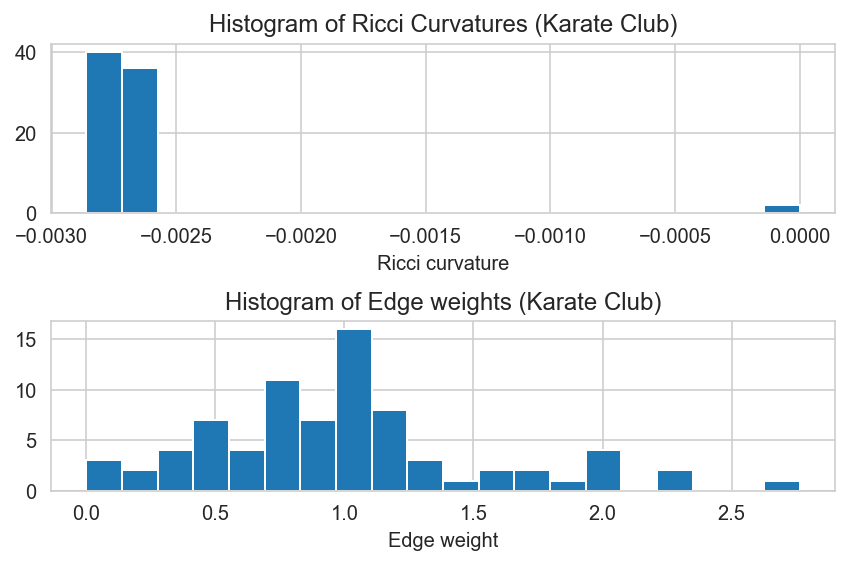

In [10]:
show_results(G_rf)

## Ricci flow for Community detection

### Visualized the communities
- We can apply Ricci flow to detect communities in graph.
- To visualized the communities in graph, let's first draw the graph and color the nodes with its community.

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


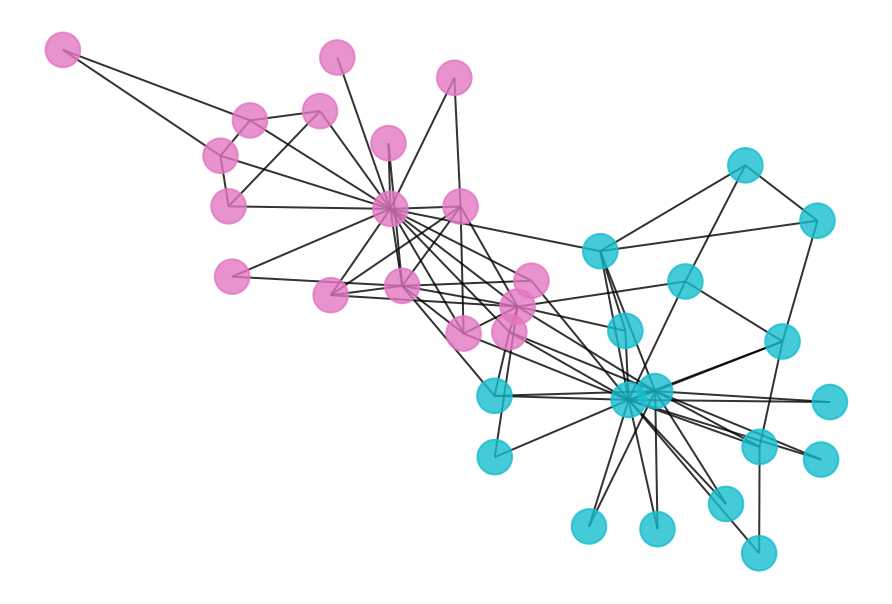

In [11]:
def draw_graph(G):
    """
    A helper function to draw a nx graph with community.
    """
    groups =nx.get_node_attributes(G,'club').values()
    color_list = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    color_dict = dict(zip(groups, color_list))
        
    nx.draw_spring(G,seed=0, nodelist=G.nodes(),
                   node_color=[color_dict[x] for x in groups],
                   alpha=0.8)

draw_graph(G_rf)

### Detect the communities
- To detect the communities of the graph, we can try a simple but effected method -- remove all edges with weight greater than a threshold.
- By observing the histogram of edge weights, let's set the threshold to be 1.5 or 1.0, and apply modularity and Adjust Rand Index(ARI) as clustering metrics to evaluate the clustering result.
    - Modularity: A clustering metrics define **without groundtruth**.
    - ARI: A clustering metrics define **with groundtruth**.

In [12]:
def ARI(G, cc, clustering_label="club"):
    """
    Computer the Adjust Rand Index (clustering accuray) of clustering "cc" with clustering_label as ground truth.
    :param G: A networkx graph
    :param cc: A clustering result as list of connected components list
    :param clustering_label: Node label for clustering groundtruth 
    """
    
    complexlist=nx.get_node_attributes(G, clustering_label)

    le = preprocessing.LabelEncoder()
    y_true=le.fit_transform(list(complexlist.values()))

    predict_dict={}
    for idx, comp in enumerate(cc):
        for c in list(comp):
            predict_dict[c]=idx
    y_pred=[]
    for v in complexlist.keys():
        y_pred.append(predict_dict[v])
    y_pred=np.array(y_pred)
    
    return metrics.adjusted_rand_score(y_true,y_pred)
    
    
def my_surgery(G_origin: nx.Graph(), weight="weight", cut=0):
    """
    A simple surgery function that remove the edges with weight above a threshold
    :param G: A weighted networkx graph
    :param weight: Name of edge weight to cut
    :param cut: Manually assign cut point
    :return: A weighted networkx graph after surgery
    """
    G=G_origin.copy()
    w = nx.get_edge_attributes(G, weight)

    assert cut >=0, "Cut value should be greater than 0."
    if not cut:
        cut = (max(w.values()) - 1.0) * 0.6 + 1.0  # Guess a cut point as default
    
    to_cut = []
    for n1, n2 in G.edges():
        if G[n1][n2][weight] > cut:
            to_cut.append((n1, n2))
    print("*************** Surgery time ****************")
    print("* Cut %d edges." % len(to_cut))
    G.remove_edges_from(to_cut)
    print("* Number of nodes now: %d" % G.number_of_nodes())
    print("* Number of edges now: %d" % G.number_of_edges())
    cc=list(nx.connected_components(G))
    print("* Modularity now: %f " % nx.algorithms.community.modularity(G,cc))
    print("* ARI now: %f " % ARI(G,cc))
    print("*********************************************")
    
    return G

*************** Surgery time ****************
* Cut 12 edges.
* Number of nodes now: 34
* Number of edges now: 66
* Modularity now: 0.063123 
* ARI now: 0.072402 
*********************************************


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


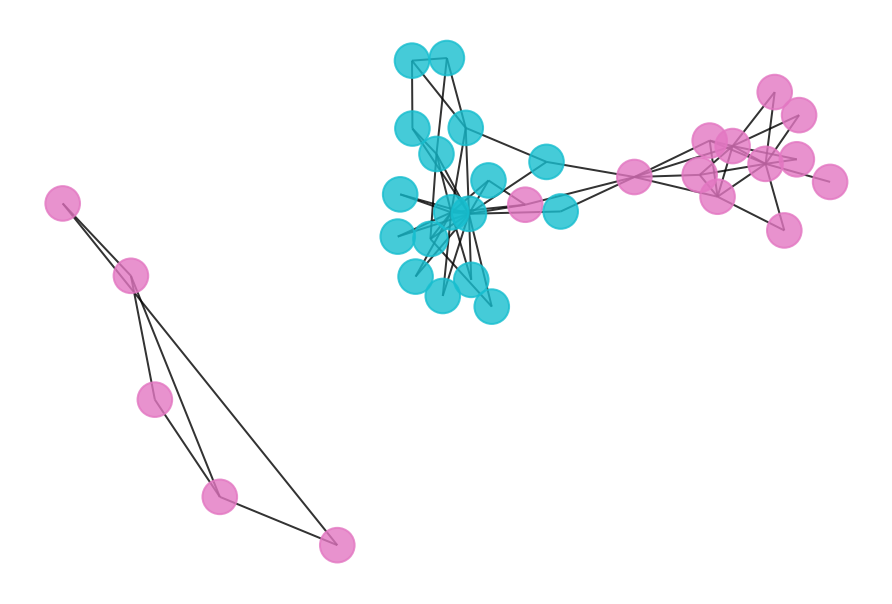

In [13]:
draw_graph(my_surgery(G_rf, cut=1.5))

*************** Surgery time ****************
* Cut 37 edges.
* Number of nodes now: 34
* Number of edges now: 41
* Modularity now: 0.687399 
* ARI now: 0.321943 
*********************************************


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


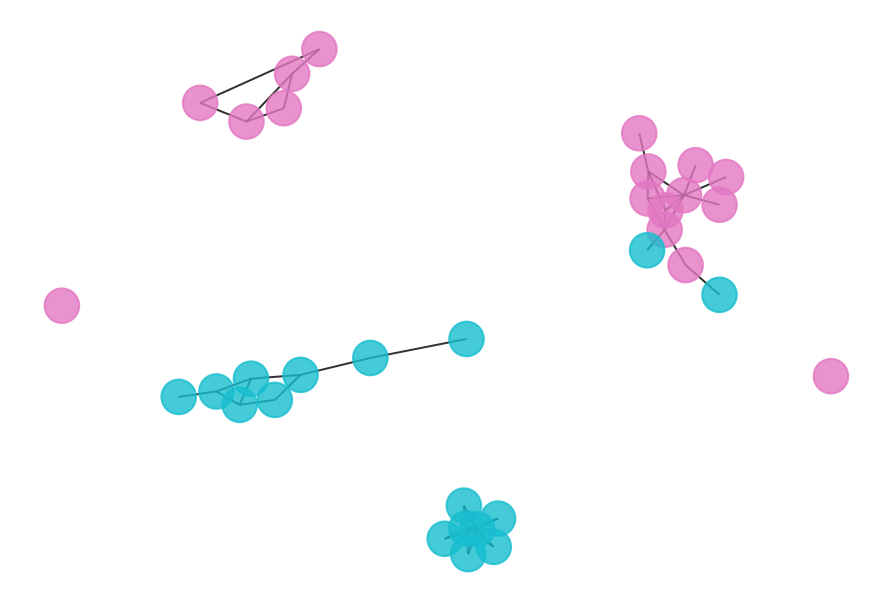

In [14]:
draw_graph(my_surgery(G_rf, cut=1.0))

- Both of the above cutoffs are not that promising. It seems to be a lot of works to find a good cutoff point, let's try to automize it  by scan thrugh the possible cutoff points and plot the corresponding accuracy.

In [15]:
def check_accuracy(G_origin,weight="weight"):
    """
    Check the accuracy of the Ricci flow edge weight cutoff.
    """
    
    G=G_origin.copy()
    mod, ari = [], []
    
    maxw = max(nx.get_edge_attributes(G, weight).values())
    for cutoff in np.arange(maxw, 0, -0.025):
        trimlist = []
        for n1,n2 in G.edges():
            if G[n1][n2][weight] > cutoff:
                trimlist.append((n1, n2))
        G.remove_edges_from(trimlist)
        cc = list(nx.connected_components(G))
        mod.append(nx.algorithms.community.modularity(G, cc))
        ari.append(ARI(G, cc))
    
    plt.xlim(maxw, 0)
    plt.xlabel("Edge weight cutoff")
    plt.plot(np.arange(maxw,0,-0.025), mod, alpha=0.8)
    plt.plot(np.arange(maxw,0,-0.025), ari, alpha=0.8)
    plt.legend(['Modularity', 'Adjust Rand Index'])

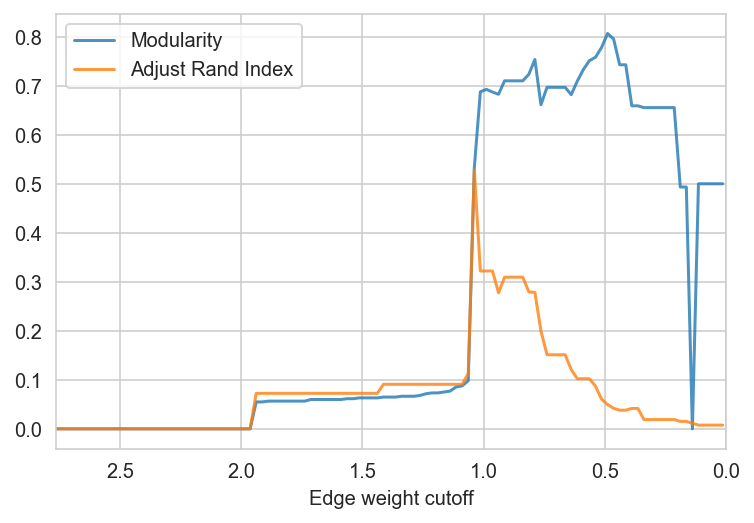

In [16]:
check_accuracy(G_rf)

- By the figure above, the best accuracy we can have is ~0.52 with ARI when cutoff set to ~1.04.

*************** Surgery time ****************
* Cut 33 edges.
* Number of nodes now: 34
* Number of edges now: 45
* Modularity now: 0.532241 
* ARI now: 0.527902 
*********************************************


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


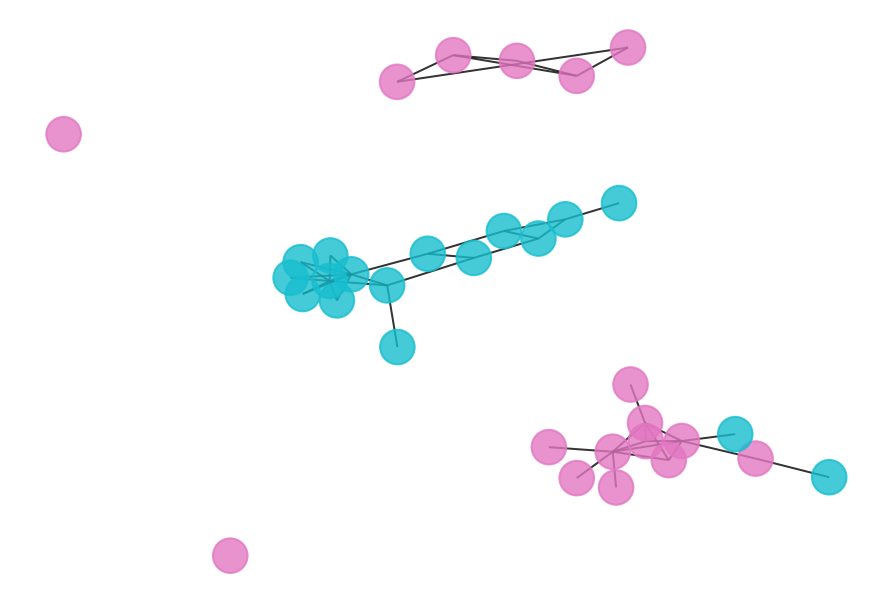

In [17]:
draw_graph(my_surgery(G_rf, cut=1.04))

### Optimal transportation and Communities
- The key of Ollivier-Ricci curvature is optimal transportation. The above example demonstrate the result of Ricci flow with Lin and Yau's setting of probability distribution for optimal transportation while uniformly distriubte probabilities to neighbors. For node $x$ and it's neighbor set $\pi(x)$, they define the probability distribution with $\alpha\in[0,1]$ as the followings: 
\begin{equation*}
m^{\alpha}_x(x_i)=
\begin{cases}
\alpha & \mbox{ if } x_i = x\\
1-\alpha & \mbox{ if } x_i \in \pi(x)\\
0 & \mbox{ otherwise }
\end{cases}
\end{equation*}

- We proposed a more generalized setting of probability distributions as the following, where $C=\sum_{x_i \in \pi(x)} b^{-d(x,x_i)^p}$:

\begin{equation*}
m^{\alpha,p}_x(x_i)=
\begin{cases}
\alpha & \mbox{ if } x_i = x\\
\frac{1-\alpha}{C}\cdot  b^{-d(x,x_i)^p} & \mbox{ if } x_i \in \pi(x)\\
0 & \mbox{ otherwise }
\end{cases}
\end{equation*}

- This setting allows us to flavor the probability distribution by the edge weight. If we take $p=0$, then the distribution fall back to Lin and Yau's setting, if we set $b=\exp$ and $p=2$, then this distribution is similar to "heat diffusion". It turns out that for most of the case, $(b,p)=(\exp,1)$ and $(b,p)=(\exp,2)$ performs the best for community detection task.


#### Parameters
**alpha**: The parameter for the probability distribution, range from [0 ~ 1]. It means the share of mass to leave on the original node. E.g. $x \rightarrow y$, alpha = 0.4 means 0.4 for $x$, 0.6 to evenly spread to $x$'s nbr. Default: 0.5
            
**base**: Base variable for weight distribution. Default: `math.e`
    
**exp_power**: Exponential power for weight distribution. Default: 0

**method**: Transportation method. ["OTD", "ATD", "Sinkhorn"] 

    - "OTD" for Optimal Transportation Distance. 
    - "ATD" for Average Transportation Distance.
    - "Sinkhorn" for OTD approximated Sinkhorn distance (faster).


- Let's retry the karate club example with different settings:

In [18]:
orf2 = OllivierRicci(G, alpha=0.5, base=math.e, exp_power=1, proc=8)
orf2.compute_ricci_flow(iterations=50)
G_rf2 = orf2.G.copy()

Edge weight not detected in graph, use "weight" as edge weight.

13.797710 secs for Ricci flow computation.


Karate Club Graph, first 5 edges: 
Ollivier-Ricci curvature of edge (0,1) is -0.018183
Ollivier-Ricci curvature of edge (0,2) is -0.000490
Ollivier-Ricci curvature of edge (0,3) is -0.009165
Ollivier-Ricci curvature of edge (0,4) is -0.001731
Ollivier-Ricci curvature of edge (0,5) is -0.002200


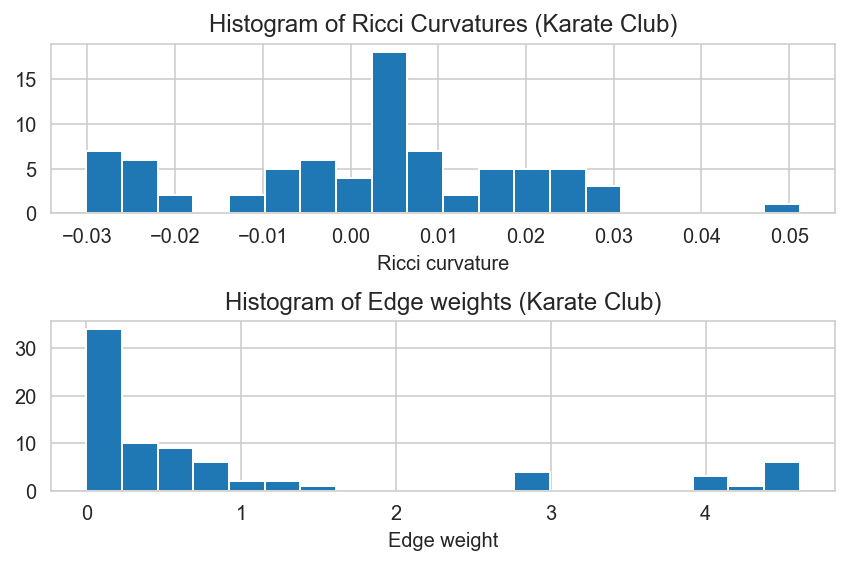

In [19]:
show_results(G_rf2)

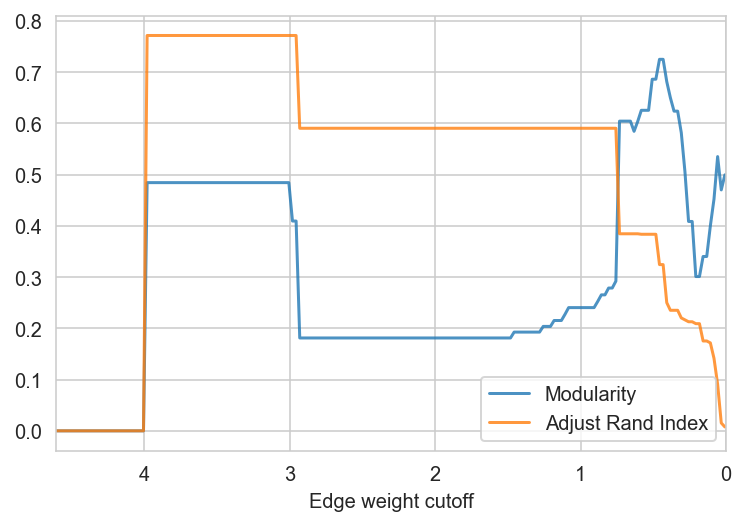

In [20]:
check_accuracy(G_rf2)

- Now we acquire a higher ARI with ~0.78, this is almost the best result we can get for the karate club graph for most of the community detection algorithm. Noice that the trend of ARI and modularity is similar in cutoff range grater than 1, this gives us a clue when community groundtruth is not available, we can always find the plateau of modularity curve and decide a cutoff point.

*************** Surgery time ****************
* Cut 10 edges.
* Number of nodes now: 34
* Number of edges now: 68
* Modularity now: 0.484442 
* ARI now: 0.771626 
*********************************************


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


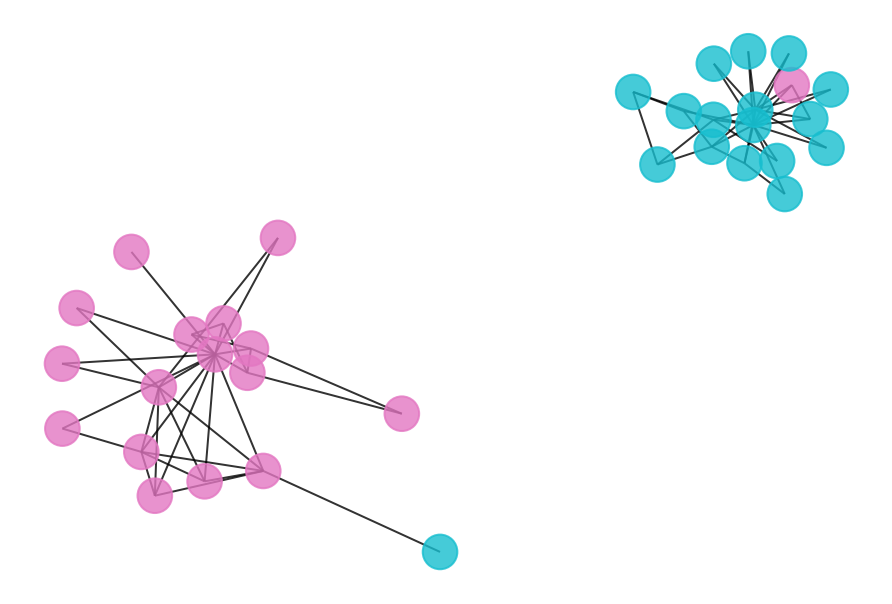

In [21]:
draw_graph(my_surgery(G_rf2, cut=3))

- Here is the result if we choose the second highest plateau of the modularity curve as the cutoff point, we basically separate the community into a hierarchical clustering. 

*************** Surgery time ****************
* Cut 14 edges.
* Number of nodes now: 34
* Number of edges now: 64
* Modularity now: 0.181248 
* ARI now: 0.590553 
*********************************************


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


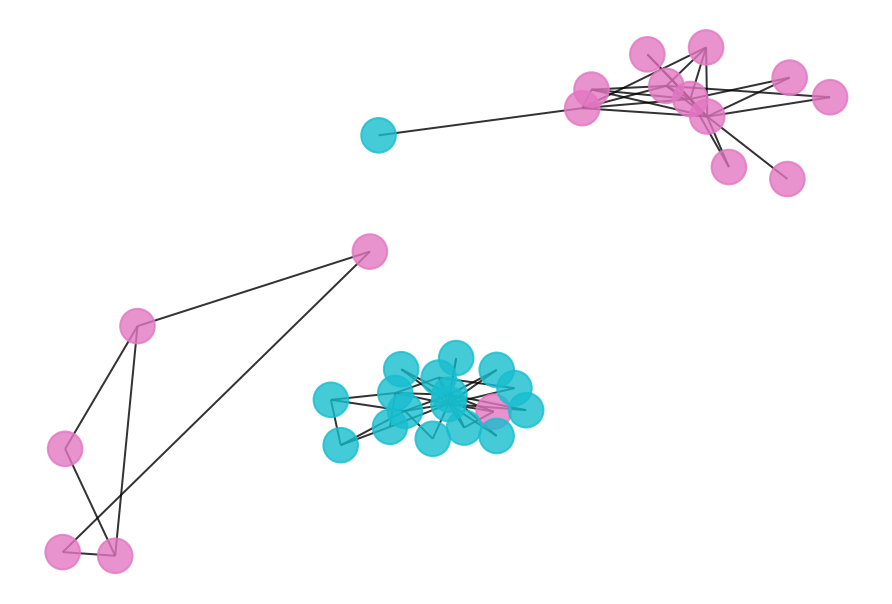

In [26]:
draw_graph(my_surgery(G_rf2, cut=2))